In [1]:
from pathlib import Path

import os
import torch
import albumentations as A

from tracenet.datasets import CellDetection, FilamentDetection
from tracenet import get_train_transform, get_valid_transform, collate_fn
from tracenet.utils import plot_results

In [2]:
# data = 'cell'
data = 'mt'

In [3]:
if data == 'cell':
    path = Path('celldata')
    ds = CellDetection(
        path / 'maxprojections', path / 'bboxes_for_cell_detection_val.csv', 
        get_train_transform(bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    )
else:
    path = Path('mtdata/val')
    files = os.listdir(path / 'img')
    files.sort()
    ds = FilamentDetection(
        [path / 'img' / fn for fn in files],
        [path / 'gt' / fn.replace('.tif', '.csv') for fn in files], 
        get_train_transform(keypoint_params=A.KeypointParams(format='xy', label_fields=['point_labels'], remove_invisible=False, angle_in_degrees=True))
    )

dl = torch.utils.data.DataLoader(ds, shuffle=False, collate_fn=collate_fn, batch_size=2, num_workers=2)

In [4]:
imgs, targets = next(iter(dl))

/research/sharedresources/cbi/common/Anna/codes/trace-net/tracenet/datasets/filament.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  boxes = torch.as_tensor(boxes, dtype=torch.float32)
/research/sharedresources/cbi/common/Anna/codes/trace-net/tracenet/datasets/filament.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  boxes = torch.as_tensor(boxes, dtype=torch.float32)


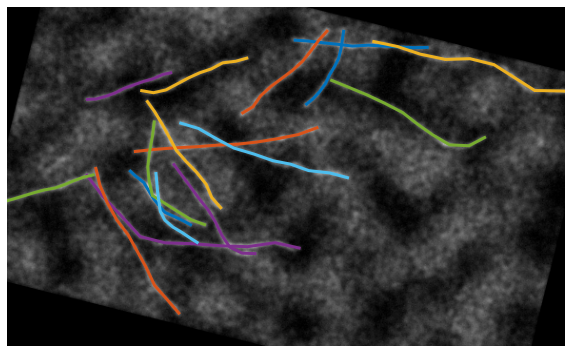

In [5]:
ind = 1
plot_results(imgs[ind], targets[ind]['boxes'])